In [3]:
!pip install catboost --upgrade
!pip install scikit-learn --upgrade

     |████████████████████████████████| 69.2 MB 9.2 kB/s 
     |████████████████████████████████| 22.3 MB 69 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [4]:
# If you have installation questions, please reach out

import pandas as pd # data storage
import catboost as cats # graident boosting 

from catboost import CatBoostRegressor, Pool

import datetime
import numpy as np  # math and stuff
import matplotlib.pyplot as plt # plotting utility
import sklearn # ML and stats

print('catboost ver:', cats.__version__)
print('scikit ver:', sklearn.__version__)

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import max_error, mean_squared_error, median_absolute_error
from sklearn.feature_selection import RFECV

catboost ver: 0.26
scikit ver: 0.24.2


In [5]:
# df = pd.read_csv('drive/My Drive/1_lewis_research/core_to_wl_merge/Merged_dataset_inner_imputed_12_21_2020.csv')
df = pd.read_csv('drive/My Drive/1_lewis_research/core_to_wl_merge/OS0_Merged_dataset_imputed_3_1_2021.csv')

# df2 = pd.read_csv('drive/My Drive/1_lewis_research/core_to_wl_merge/offset_test_imputed_2_27_2021.csv')
df2 = pd.read_csv('drive/My Drive/1_lewis_research/core_to_wl_merge/OS1_offset_imputed_test.csv')

df3 = pd.read_csv('drive/My Drive/1_lewis_research/core_to_wl_merge/OS2_offset_imputed_test.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'LiveTime2','ScanTime2', 'LiveTime1','ScanTime1',
              'ref_num', 'API', 'well_name', 'sample_num' ], axis=1)

print(df.columns.values) # printing all column names

df.describe()

['depth_ft' 'USGS_ID' 'CAL' 'GR' 'DT' 'SP' 'DENS' 'PE' 'RESD' 'PHIN'
 'PHID' 'PE_smooth' 'GR_smooth' 'gz_linear_interp' 'gz_pchip_interp'
 'perm_air_md' 'perm_klink_md' 'He_por' 'horz_perm_md' 'effective_por'
 'por_percent' 'stress_swanson_perm_md' 'sample' 'Na' 'Na Err' 'Mg'
 'Mg Err' 'Al' 'Al Err' 'Si' 'Si Err' 'P' 'P Err' 'S' 'S Err' 'K' 'K Err'
 'Ca' 'Ca Err' 'Ti' 'Ti Err' 'Cr' 'Cr Err' 'Mn' 'Mn Err' 'Fe' 'Fe Err'
 'Co' 'Co Err' 'Ni' 'Ni Err' 'Cu' 'Cu Err' 'Zn' 'Zn Err' 'Ba' 'Ba Err']


,depth_ft,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,PE_smooth,GR_smooth,gz_linear_interp,gz_pchip_interp,perm_air_md,perm_klink_md,He_por,horz_perm_md,effective_por,por_percent,stress_swanson_perm_md,Na,Na Err,Mg,Mg Err,Al,Al Err,Si,Si Err,P,P Err,S,S Err,K,K Err,Ca,Ca Err,Ti,Ti Err,Cr,Cr Err,Mn,Mn Err,Fe,Fe Err,Co,Co Err,Ni,Ni Err,Cu,Cu Err,Zn,Zn Err,Ba,Ba Err
count,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,508.000000,510.000000,510.000000,25.000000,25.000000,24.000000,24.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.0,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000
mean,5397.863358,0.468406,0.325999,0.430844,0.811259,0.613371,0.351642,1.011018,0.172737,0.172737,0.351702,0.326029,4.913576,4.910244,81.002187,73.797216,14.267039,8.304000,11.808000,8.420833,1.646585,1.132042,0.025387,0.762913,0.011739,3.490170,0.012272,32.981494,0.033185,0.048516,0.001821,0.728955,0.002247,1.675288,0.005710,2.779623,0.005543,0.190546,0.001373,0.005787,0.000116,0.016520,0.000705,1.941109,0.003196,0.001315,0.0,0.004773,0.000100,0.003211,0.000822,0.006309,0.000763,0.090289,0.004689
std,5106.156677,0.191316,0.237404,0.263514,0.162843,0.214604,0.186912,1.503608,0.226664,0.226664,0.178735,0.229901,1.738128,1.751499,173.917355,161.251984,9.365678,3.161814,4.446902,3.050728,3.741652,0.777851,0.004405,0.488501,0.002843,1.415185,0.002607,4.940991,0.002003,0.023636,0.000221,0.795110,0.001252,0.761818,0.001383,2.045850,0.002189,0.088087,0.000297,0.002270,0.000075,0.024982,0.000128,1.472163,0.001193,0.000821,0.0,0.000796,0.000002,0.004429,0.000114,0.004559,0.000100,0.065308,0.000594
min,150.000000,0.000000,0.000000,0.003752,0.000000,0.000000,0.000000,-0.744314,0.000570,0.000570,0.004477,0.000258,1.204296,1.199972,0.001000,0.000000,1.000000,1.900000,5.900000,4.000000,0.000390,0.126200,0.016000,0.047000,0.006800,0.992200,0.007100,8.429500,0.021700,0.000000,0.001100,0.040300,0.000600,0.118400,0.002000,0.133500,0.001400,0.048500,0.000800,0.000000,-0.001200,0.000000,0.000500,0.270700,0.001300,0.000200,0.0,0.002700,0.000100,0.000000,0.000200,0.000000,0.000500,0.000000,0.003100
25%,450.725000,0.360072,0.122318,0.174146,0.743878,0.424460,0.216157,-0.037336,0.004595,0.004595,0.220800,0.131058,3.538724,3.531571,0.040750,0.020250,8.300000,7.900000,8.400000,6.800000,0.001140,0.768500,0.023400,0.293850,0.009100,2.411025,0.010200,29.728050,0.032000,0.032400,0.001700,0.182225,0.001200,1.069725,0.004600,1.103025,0.003600,0.121875,0.001100,0.004400,0.000100,0.003200,0.000600,0.964250,0.002300,0.000700,0.0,0.004300,0.000100,0.000000,0.000700,0.002700,0.000700,0.053200,0.004300
50%,1614.650000,0.554827,0.275825,0.471657,0.867010,0.605516,0.329327,0.795008,0.005532,0.005532,0.337049,0.283192,4.307541,4.256191,0.065500,0.037500,9.300000,9.500000,10.600000,7.300000,0.002070,1.057300,0.025200,0.692000,0.011700,3.133250,0.011700,31.893100,0.033300,0.047250,0.001800,0.461450,0.001900,1.560450,0.005800,2.593250,0.005700,0.160300,0.001300,0.005400,0.000100,0.014200,0.000700,1.658800,0.003100,0.001200,0.0,0.004800,0.000100,0.000000,0.000800,0.005400,0.000800,0.079300,0.004700
75%,9649.575000,0.602566,0.530980,0.662807,0.925012,0.830179,0.470706,1.378387,0.332503,0.332503,0.463317,0.525448,6.615175,6.633493,71.375000,59.675000,26.610000,10.300000,13.800000,9.200000,0.949777,1.322750,0.026700,1.192400,0.014400,4.531475,0.014400,37.944075,0.034700,0.061800,0.002000,0.941100,0.002900,2.291400,0.006900,3.872700,0.007000,0.258025,0.001600,0.006800,0.000100,0.023400,0.000800,2.616775,0.003900,0.001700,0.0,0.005200,0.000100,0.006300,0.000900,0.009200,0.0

In [7]:
dataset = df[[
    'CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
    'RESD', 'PHIN', 'PHID', 'GR_smooth', 
    'PE_smooth',
    'gz_pchip_interp' # Trying to predict gz_pchip_interp
]]

dataset.replace('NaN',np.nan, regex=True, inplace=True)# Should be good already
# dataset = dataset.dropna() # not needed

dataset.head(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,GR_smooth,PE_smooth,gz_pchip_interp
0,0.630495,0.187403,0.054025,0.582081,0.829176,0.349137,0.982069,0.001692,0.001692,0.183350,0.366294,4.0320
1,0.629618,0.186340,0.054025,0.583138,0.828532,0.346560,0.970108,0.001674,0.001674,0.185719,0.364550,3.9834
2,0.628741,0.185373,0.054025,0.584257,0.827725,0.349993,0.958103,0.001662,0.001662,0.188207,0.362606,3.9836


In [8]:
# Features we will use for prediction
X = dataset[['CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
        'RESD', 'PHIN', 'PHID', 
        'GR_smooth', 
        'PE_smooth']]

# What we are trying to predict
Y = dataset[['gz_pchip_interp']]

Y_array = np.array(Y.values)

In [9]:
seed = 42 # random seed is only used if you want to compare exact answers with friends 
test_size = 0.25 # how much data you want to withold, .15 - 0.3 is a good starting point

X_train, X_test, y_train, y_test = train_test_split(X.values, Y_array, test_size=test_size)

In [10]:
preds = 0
preds2 = 0

def catboost_gz(X_train, X_test, y_train, y_test, export_name, max_iter=500):

  model = CatBoostRegressor(objective='RMSE',
                            task_type='GPU',
                            iterations=max_iter)
  
  model.fit(X_train, y_train, verbose=1000 )
  preds = model.predict(X_test)

  # Stats
  rmse = mean_squared_error(y_test, preds, squared=False)
  print("Root Mean Squared Error: %f" % (rmse))
  max = max_error(y_test, preds)
  print("Max Error: %f" % (max))
  MAE= median_absolute_error(y_test, preds)
  print("Median Abs Error: %f" % (max))

  # Let's Tune
  grid = {'learning_rate': [0.1, 0.2, 0.4],
        'depth': [6, 8, 10,  12, 14],
        'l2_leaf_reg': [2, 3, 4 , 5, 6 ]}

  model_grid = CatBoostRegressor(objective='RMSE',
                                 task_type='GPU',
                                 iterations=max_iter)

  # Grid Search
  grid_search_result = model_grid.grid_search(grid, 
                                            X=X_train, 
                                            y=y_train, 
                                            cv=5,
                                            verbose=False)
  model2 = CatBoostRegressor(objective='RMSE',
                           depth=grid_search_result['params']['depth'],
                           l2_leaf_reg=grid_search_result['params']['l2_leaf_reg'],
                           learning_rate=grid_search_result['params']['learning_rate'],
                           iterations=max_iter)

  model2.fit(X_train, y_train, verbose=500)
  preds2 = model2.predict(X_test)

  # Stats for the second round
  rmse2 = mean_squared_error(y_test, preds2, squared=False)
  print("Root Mean Squared Error: %f" % (rmse2))
  max2 = max_error(y_test, preds2)
  print("Max Error: %f" % (max2))
  MAE2= median_absolute_error(y_test, preds2)
  print("Median Abs Error: %f" % (MAE2))

  x = datetime.datetime.now()

  d = {'target': [Y.columns.values, Y.columns.values],
     'MSE': [rmse, rmse2],
     'MAE': [MAE, MAE2],
     'MaxError': [max, max2], 
     'iter': [max_iter, max_iter],
     'day': [x.day, x.day], 
     'month':[x.month, x.month], 
     'year':[x.year, x.year],
     'model':['catboost', 'catboost'],
     'version':[cats.__version__, cats.__version__ ]}

  results = pd.DataFrame(data=d)

  filepath = 'drive/My Drive/1_lewis_research/analysis/experiments/catboost/catboost_results/'
  results.to_csv(filepath+export_name)

  return results

# Iteration

In [17]:
iter =  30   #300

# offset 0

In [ ]:
catboost_gz(X_train, X_test, y_train, y_test, 'catboost_gz.csv', iter)

Streaming output truncated to the last 5000 lines.
64:	learn: 0.8702507	test: 1.0087426	best: 1.0086480 (62)	total: 850ms	remaining: 3.07s
65:	learn: 0.8651004	test: 1.0050552	best: 1.0050552 (65)	total: 870ms	remaining: 3.08s
66:	learn: 0.8646349	test: 1.0051546	best: 1.0050552 (65)	total: 877ms	remaining: 3.05s
67:	learn: 0.8558101	test: 1.0002373	best: 1.0002373 (67)	total: 897ms	remaining: 3.06s
68:	learn: 0.8557632	test: 1.0000433	best: 1.0000433 (68)	total: 906ms	remaining: 3.03s
69:	learn: 0.8525320	test: 0.9972186	best: 0.9972186 (69)	total: 926ms	remaining: 3.04s
70:	learn: 0.8498738	test: 0.9950541	best: 0.9950541 (70)	total: 945ms	remaining: 3.05s
71:	learn: 0.8498557	test: 0.9951518	best: 0.9950541 (70)	total: 952ms	remaining: 3.01s
72:	learn: 0.8485546	test: 0.9941493	best: 0.9941493 (72)	total: 971ms	remaining: 3.02s
73:	learn: 0.8471705	test: 0.9924753	best: 0.9924753 (73)	total: 982ms	remaining: 3s
74:	learn: 0.8460307	test: 0.9912028	best: 0.9912028 (74)	total: 1s	rema

# offset 1

In [15]:
df2 = df2.drop(['Unnamed: 0', 'Unnamed: 0.1', 'LiveTime2','ScanTime2', 'LiveTime1','ScanTime1',
              'ref_num', 'API', 'well_name', 'sample_num' ], axis=1)

dataset2 = df2[[
    'CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
    'RESD', 'PHIN', 'PHID', 'GR_smooth', 
    'PE_smooth',
    'gz_pchip_interp' # Trying to predict gz_pchip_interp
]]

# Features we will use for prediction
X2 = dataset2[['CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
        'RESD', 'PHIN', 'PHID', 
        'GR_smooth', 
        'PE_smooth']]

# What we are trying to predict
Y = dataset2[['gz_pchip_interp']]

Y_array2 = np.array(Y.values)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2.values, Y_array2, test_size=test_size)

In [18]:
catboost_gz(X_train2, X_test2, y_train2, y_test2, 'OS1_catboost_gz.csv', iter)

Learning rate set to 0.5
0:	learn: 1.2845430	total: 3.54ms	remaining: 103ms
29:	learn: 0.7307106	total: 78.6ms	remaining: 0us
Root Mean Squared Error: 0.805091
Max Error: 5.082947
Median Abs Error: 5.082947
0:	learn: 4.7248638	test: 4.6889774	best: 4.6889774 (0)	total: 10.2ms	remaining: 294ms
1:	learn: 4.2802506	test: 4.2509479	best: 4.2509479 (1)	total: 19.1ms	remaining: 267ms
2:	learn: 3.8844439	test: 3.8599587	best: 3.8599587 (2)	total: 28.2ms	remaining: 254ms
3:	learn: 3.5299380	test: 3.5082811	best: 3.5082811 (3)	total: 36.8ms	remaining: 239ms
4:	learn: 3.2138714	test: 3.1967167	best: 3.1967167 (4)	total: 45.5ms	remaining: 228ms
5:	learn: 2.9301328	test: 2.9173754	best: 2.9173754 (5)	total: 54.3ms	remaining: 217ms
6:	learn: 2.6777131	test: 2.6681470	best: 2.6681470 (6)	total: 63.3ms	remaining: 208ms
7:	learn: 2.4515545	test: 2.4456184	best: 2.4456184 (7)	total: 72.1ms	remaining: 198ms
8:	learn: 2.2521462	test: 2.2489986	best: 2.2489986 (8)	total: 80.8ms	remaining: 189ms
9:	learn: 

,target,MSE,MAE,MaxError,iter,day,month,year,model,version
0,[gz_pchip_interp],0.805091,0.277021,5.082947,30,3,8,2021,catboost,0.26
1,[gz_pchip_interp],0.709192,0.182461,4.998710,30,3,8,2021,catboost,0.26


# Offset 2

In [13]:
df3 = df3.drop(['Unnamed: 0', 'Unnamed: 0.1', 'LiveTime2','ScanTime2', 'LiveTime1','ScanTime1',
              'ref_num', 'API', 'well_name', 'sample_num' ], axis=1)

dataset3 = df3[[
    'CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
    'RESD', 'PHIN', 'PHID', 'GR_smooth', 
    'PE_smooth',
    'gz_pchip_interp' # Trying to predict gz_pchip_interp
]]

# Features we will use for prediction
X3 = dataset3[['CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
        'RESD', 'PHIN', 'PHID', 
        'GR_smooth', 
        'PE_smooth']]

# What we are trying to predict
Y3 = dataset3[['gz_pchip_interp']]

Y_array3 = np.array(Y3.values)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3.values, Y_array3, test_size=test_size)

KeyError: ignored

In [14]:
catboost_gz(X_train3, X_test3, y_train3, y_test3, 'OS2_catboost_gz_RFECV.csv', iter)

Learning rate set to 0.5
0:	learn: 1.2189535	total: 4.67ms	remaining: 42ms
9:	learn: 0.7933453	total: 26ms	remaining: 0us
Root Mean Squared Error: 0.869696
Max Error: 4.952876
Median Abs Error: 4.952876
0:	learn: 4.7365160	test: 4.6548703	best: 4.6548703 (0)	total: 11ms	remaining: 99.2ms
1:	learn: 4.2872393	test: 4.2094725	best: 4.2094725 (1)	total: 20.9ms	remaining: 83.4ms
2:	learn: 3.8855985	test: 3.8097129	best: 3.8097129 (2)	total: 29.4ms	remaining: 68.7ms
3:	learn: 3.5256546	test: 3.4538239	best: 3.4538239 (3)	total: 38ms	remaining: 56.9ms
4:	learn: 3.2040180	test: 3.1339947	best: 3.1339947 (4)	total: 46.5ms	remaining: 46.5ms
5:	learn: 2.9152527	test: 2.8474913	best: 2.8474913 (5)	total: 55ms	remaining: 36.7ms
6:	learn: 2.6573797	test: 2.5924847	best: 2.5924847 (6)	total: 63.5ms	remaining: 27.2ms
7:	learn: 2.4264263	test: 2.3645569	best: 2.3645569 (7)	total: 75.5ms	remaining: 18.9ms
8:	learn: 2.2239845	test: 2.1639066	best: 2.1639066 (8)	total: 84.4ms	remaining: 9.38ms
9:	learn: 2

,target,MSE,MAE,MaxError,iter,day,month,year,model,version
0,[gz_pchip_interp],0.869696,0.339368,4.952876,10,3,8,2021,catboost,0.26
1,[gz_pchip_interp],0.786421,0.260120,4.617163,10,3,8,2021,catboost,0.26


# Recursive feature elimination with cross-validation

In [44]:
df3 = pd.read_csv('drive/My Drive/1_lewis_research/core_to_wl_merge/OS2_offset_imputed_test.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [45]:
df3

,Unnamed: 0,depth_ft,USGS_ID,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,PE_smooth,GR_smooth,Unnamed: 0.1,gz_linear_interp,gz_pchip_interp,ref_num,perm_air_md,perm_klink_md,He_por,API,well_name,horz_perm_md,effective_por,por_percent,stress_swanson_perm_md,sample_num,sample,Na,Na Err,Mg,Mg Err,Al,Al Err,Si,Si Err,P,P Err,S,S Err,K,K Err,Ca,Ca Err,Ti,Ti Err,Cr,Cr Err,Mn,Mn Err,Fe,Fe Err,Co,Co Err,Ni,Ni Err,Cu,Cu Err,Zn,Zn Err,Ba,Ba Err,ScanTime1,LiveTime1,ScanTime2,LiveTime2
0,0,7741.0,F028,0.595503,0.167502,0.042458,0.590006,0.831504,0.334348,1.285381,0.001736,0.001736,0.374193,0.192619,10869,4.0313,4.0320,F-1,NaN,NaN,NaN,4.900722e+09,FILLMORE 2-19,NaN,NaN,14.5,5.55,675.0,1500675-Mudrock Dual,1.2770,0.0263,0.6987,0.0116,2.8101,0.0112,33.9921,0.0332,0.0826,0.0021,0.1116,0.0011,0.9947,0.0045,4.5640,0.0073,0.1641,0.0013,0.0085,0.0001,0.0186,0.0008,1.4531,0.0029,0.0011,0.0,0.0044,0.0001,0.0,0.0008,0.0023,0.0008,0.0663,0.0049,60.0,41.48,-1.0,-1.0
1,1,7741.1,F028,0.594445,0.157977,0.059848,0.588537,0.831224,0.326622,1.373018,0.001729,0.001729,0.374193,0.189212,10870,3.9834,3.9834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,7741.2,F028,0.593491,0.149265,0.059848,0.587063,0.831140,0.320642,1.463893,0.001723,0.001723,0.373821,0.185619,10871,3.9837,3.9836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,7741.3,F028,0.593725,0.145970,0.057717,0.585640,0.831003,0.323795,1.558126,0.001718,0.001718,0.373024,0.182036,10872,3.9840,3.9840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,7741.4,F028,0.594523,0.144293,0.056390,0.584115,0.831488,0.333005,1.655840,0.001712,0.001712,0.371431,0.178470,10873,3.9843,3.9843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12025,12025,13378.0,PDRMT,0.080749,0.763390,0.318322,0.502314,0.628529,0.428994,-0.163882,0.378053,0.378053,0.471810,0.766522,2819,4.3717,4.3658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,503.0,1500503-Mudrock Dual,0.5632,0.0196,0.5084,0.0102,1.8027,0.0094,35.4358,0.0311,0.1020,0.0024,0.2357,0.0015,0.5846,0.0034,4.3886,0.0066,0.1207,0.0012,0.0114,0.0002,0.0153,0.0007,1.0049,0.0024,0.0008,0.0,0.0049,0.0001,0.0,0.0007,0.0034,0.0008,0.1478,0.0056,60.0,40.11,-1.0,-1.0
12026,12026,13378.1,PDRMT,0.080822,0.767160,0.319374,0.501919,0.636449,0.432019,-0.152552,0.369177,0.369177,0.477121,0.767302,2820,6.6922,6.7092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12027,12027,13378.2,PDRMT,0.080896,0.769669,0.321289,0.501597,0.647342,0.435815,-0.141083,0.360357,0.360357,0.482966,0.768093,2821,6.7190,6.7313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12028,12028,13378.3,PDRMT,0.080966,0.770943,0.323205,0.501896,0.659338,0.439788,-0.129482,0.351481,0.351481,0.489439,0.768893,2822,4.3369,4.3273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Streaming output truncated to the last 5000 lines.
101:	learn: 0.1336939	total: 265ms	remaining: 514ms
102:	learn: 0.1334855	total: 267ms	remaining: 511ms
103:	learn: 0.1333624	total: 270ms	remaining: 508ms
104:	learn: 0.1331496	total: 273ms	remaining: 506ms
105:	learn: 0.1329568	total: 275ms	remaining: 504ms
106:	learn: 0.1327623	total: 278ms	remaining: 502ms
107:	learn: 0.1325804	total: 281ms	remaining: 499ms
108:	learn: 0.1324825	total: 284ms	remaining: 497ms
109:	learn: 0.1323094	total: 287ms	remaining: 495ms
110:	learn: 0.1322705	total: 290ms	remaining: 493ms
111:	learn: 0.1321761	total: 293ms	remaining: 491ms
112:	learn: 0.1320154	total: 296ms	remaining: 489ms
113:	learn: 0.1319774	total: 298ms	remaining: 486ms
114:	learn: 0.1318311	total: 301ms	remaining: 484ms
115:	learn: 0.1317521	total: 304ms	remaining: 482ms
116:	learn: 0.1316668	total: 307ms	remaining: 479ms
117:	learn: 0.1316053	total: 310ms	remaining: 477ms
118:	learn: 0.1315332	total: 313ms	remaining: 475ms
119:	learn: 0

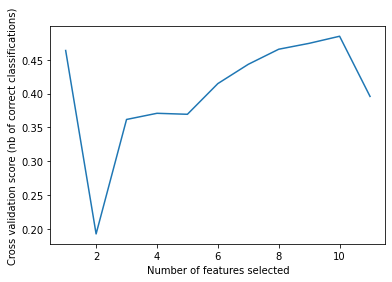

In [60]:
from sklearn.feature_selection import RFECV

df3 = pd.read_csv('drive/My Drive/1_lewis_research/core_to_wl_merge/OS2_offset_imputed_test.csv')


# Build a classification task using 3 informative features
# Features we will use for prediction
dataset3 = df3[[
    'CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
    'RESD', 'PHIN', 'PHID', 'GR_smooth', 
    'PE_smooth',
    'gz_pchip_interp' # Trying to predict gz_pchip_interp
]]

X = dataset3[['CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
        'RESD', 'PHIN', 'PHID', 
        'GR_smooth', 
        'PE_smooth']]

# What we are trying to predict
Y = dataset3[['gz_pchip_interp']]

Y_array = np.array(Y.values)

# Create the RFE object and compute a cross-validated score.
max_iter = 300

model = CatBoostRegressor(objective='MAPE',
                          task_type='GPU',
                          iterations=max_iter)

# The "accuracy" scoring is proportional to the number of correct
# classifications

min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(estimator=model, 
              step=1,
              scoring='r2',
              min_features_to_select=min_features_to_select)


rfecv.fit(X, Y_array)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")

plt.plot(range(min_features_to_select,
         len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

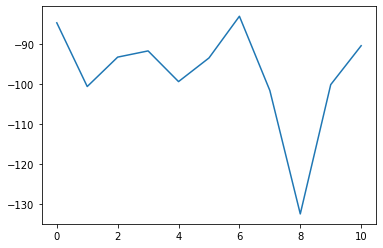

In [54]:
plt.plot(range(len(rfecv.grid_scores_)),
         rfecv.grid_scores_)